I used the Transformer Pre trained model to classify some of the reviews then built a logistic and naive bayes model to predict the other review sentiments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re
from tqdm import tqdm

# ${\textbf{Sentiment Analysis}}$

In [2]:
import nltk
from nltk.corpus import stopwords

def text_preprocessing(text):
    """
    - lowercase the sentence
    - Remove punctuations 
    - Remove other special characters
    - Remove stop words
    - Remove whitespace
    """
    
    text = text.lower()
    # remove @name if present
    text = re.sub(r"(@.*?)[\s]", ' ', text)
    # isolate and remove punctuations
    text = re.sub(r'[^\w\s\?]', ' ', text)
    # remove some special characters
    text = re.sub(r'[\;\:\|]', ' ', text)
    # remove stopwords
    text = " ".join([word for word in text.split() if word not in stopwords.words('portuguese')])
    # remove trailing whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [3]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_cv(model):
    """
    Return the average AUC score from cross-validation
    """
    kf = StratifiedKFold(5, shuffle=True, random_state=1)
    auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kf)
    
    return auc.mean()

In [4]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    print AUC and accuracy on the test set
    - plot ROC
    
    """
    
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    
    # get accuracy
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # plot ROC AUC
    plt.title('Receiver OPerating Characteristic Curve')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## ${\textbf{Pretrained Model "Transformer"}}$

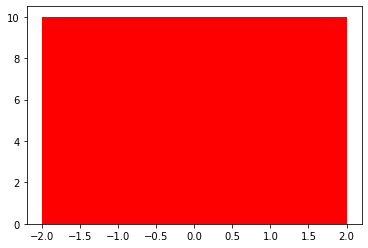

In [53]:
!pip install transformers==3.1.0

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification")

Use the pretrained model to classifier first 10,000 reviews as either +, - or neutral

In [ ]:
candidate_labels = ["positive", "negative", 'neutral']
results = []
for i in tqdm(df['review_comment_message'][:10000].values):
    sequence = i
    result = classifier(sequence, candidate_labels)
    results.append(result)

In [ ]:
labels, scores = [], []
for i in results:
    labels.append(i['labels'][0])
    scores.append(i['scores'][0])

In [ ]:
import warnings
warnings.filterwarnings('ignore')

df['sentiment_scores'] = 0
df['sentiment_class'] = 0

df['sentiment_scores'][:10000] = scores
df['sentiment_class'][:10000] = labels

In [ ]:
from wordcloud import WordCloud
def draw_wordcloud(reviews_series):
    # word cloud visualization
    allWords = ' '.join([reviews for reviews in reviews_series])
    wordCloud = WordCloud(width=500, height=300, random_state=21, max_words=150, mode='RGBA',
                          max_font_size=140, stopwords=['amp', 'https']).generate(allWords)
    plt.figure(figsize=(12, 9))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Most used words describing Satisfaction', size=20, color='#431390')
    plt.show()

In [23]:
df = pd.read_csv('review_processed2.csv')
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,sentiment_scores,sentiment_class
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,0.475009,negative
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,0.990304,positive
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,0.595055,positive
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,0.813942,positive
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,0.812546,positive


In [24]:
df['sentiment_class'].value_counts()

0           23324
positive     4175
negative     3724
neutral       101
Name: sentiment_class, dtype: int64

In [25]:
data = df[['review_comment_message', 'sentiment_scores','sentiment_class']]
test_data = data[data['sentiment_class'] == '0']
train_data = data[data['sentiment_class'] != '0']

In [26]:
print(train_data.shape, test_data.shape)

(8004, 3) (23324, 3)


In [30]:
import warnings
warnings.filterwarnings
label = []
for row in train_data['sentiment_class']:
    if row == 'positive':
        label.append(1)
    elif row == 'negative':
        label.append(-1)
    else: label.append(0)
        
train_data['sentiment_class'] = label

train_data.head()

,review_comment_message,sentiment_scores,sentiment_class
0,Recebi bem antes do prazo estipulado.,0.475009,-1
1,Parabéns lojas lannister adorei comprar pela I...,0.990304,1
2,aparelho eficiente. no site a marca do aparelh...,0.595055,1
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",0.813942,1
4,"Vendedor confiável, produto ok e entrega antes...",0.812546,1


In [31]:
len(label)

8004

In [10]:
train_data['review_comment_message'] = train_data['review_comment_message'].apply(text_preprocessing)
test_data['review_comment_message'] = test_data['review_comment_message'].apply(text_preprocessing)

In [32]:
X = train_data['review_comment_message']
y = train_data['sentiment_class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=11)

In [33]:
y.value_counts()

 1    4175
-1    3724
 0     105
Name: sentiment_class, dtype: int64

In [34]:
# now to analysis

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3), smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [35]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_test_tfidf)

# evaluate the classifier
evaluate_roc(probs, y_test)

ValueError: multiclass format is not supported

In [36]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

acc = accuracy_score(y_test, nb_model.predict(X_test_tfidf))
f1 = f1_score(y_test, nb_model.predict(X_test_tfidf), average='weighted')

print(f'Accuracy Score:: {acc:.2f}')
print(f'F1 Score:: {f1:.2f}')
print('classification report\n', classification_report(y_test, nb_model.predict(X_test_tfidf)))

Accuracy Score:: 0.80
F1 Score:: 0.79
classification report
               precision    recall  f1-score   support

          -1       0.82      0.75      0.79       756
           0       0.00      0.00      0.00        26
           1       0.78      0.87      0.82       819

    accuracy                           0.80      1601
   macro avg       0.53      0.54      0.54      1601
weighted avg       0.79      0.80      0.79      1601



In [37]:
# let try other method
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

log_reg.fit(X_train_tfidf, y_train)
preds = log_reg.predict(X_test_tfidf)

In [38]:
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='weighted')

print(f'Accuracy Score:: {acc:.2f}')
print(f'F1 Score:: {f1:.2f}')
print('classification report\n', classification_report(y_test, preds))

Accuracy Score:: 0.81
F1 Score:: 0.81
classification report
               precision    recall  f1-score   support

          -1       0.80      0.83      0.81       756
           0       0.00      0.00      0.00        26
           1       0.83      0.83      0.83       819

    accuracy                           0.81      1601
   macro avg       0.54      0.55      0.55      1601
weighted avg       0.80      0.81      0.81      1601



In [17]:
from sklearn.ensemble import GradientBoostingClassifier
grb = GradientBoostingClassifier()
grb.fit(X_train_tfidf, y_train)

preds = grb.predict(X_test_tfidf)
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='weighted')

print(f'Accuracy Score:: {acc:.2f}')
print(f'F1 Score:: {f1:.2f}')
print('classification report\n', classification_report(y_test, preds))

Accuracy Score:: 0.76
F1 Score:: 0.75
classification report
               precision    recall  f1-score   support

          -1       0.76      0.74      0.75       756
           0       0.00      0.00      0.00        26
           1       0.77      0.79      0.78       819

    accuracy                           0.76      1601
   macro avg       0.51      0.51      0.51      1601
weighted avg       0.75      0.76      0.75      1601



So we have 3 models 
we can predict for the test data and have a complete sentiment of our review

In [39]:
test_data_tfidf = tf_idf.transform(test_data['review_comment_message'])

In [40]:
test_prediction = log_reg.predict(test_data_tfidf)

In [41]:
test_data['sentiment_class'] = test_prediction
test_data['sentiment_scores'] = log_reg.predict_proba(test_data_tfidf)

In [42]:
test_data.head()

,review_comment_message,sentiment_scores,sentiment_class
8000,"Ainda não posso posso opinar pois, começei a t...",0.865202,-1
8001,a loja não me da oportunidade de estar falando...,0.774124,-1
8002,Tô aguardando pra poder avaliar melhor,0.435162,1
8003,A caixa do produto veio o pouco amassada mais ...,0.777749,-1
8004,"Site dos correios informa que foi entregue, po...",0.954552,-1


In [81]:
from google_trans_new import google_translator
translator = google_translator()
translator.translate(text=test_data['review_comment_message'][3112], lang_tgt='en')

'fast delivery before deadline '

In [41]:
test_data['sentiment_class'].value_counts()

 1    17048
-1    16763
Name: sentiment_class, dtype: int64

In [42]:
test_data['sentiment_class'].describe()

count    33811.000000
mean         0.008429
std          0.999979
min         -1.000000
25%         -1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: sentiment_class, dtype: float64